<a href="https://colab.research.google.com/github/armen1s/BOT/blob/main/1H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- CELL 1: Setup & Config ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrizations as parametrizations
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
import math

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"System Check: Running on {device}")

class Config:
    SEQ_LEN = 128          # Окно истории
    INPUT_DIM = 8          # 4 Price + 1 Vol + 3 Physics
    LATENT_DIM = 32        # Размер вектора TCN
    ATTN_HEADS = 4         # Количество голов внимания
    PROJ_DIM = 16          # Размер пространства для метрики
    BATCH_SIZE = 64
    LR = 3e-4              # Снижен для стабильности Attention
    MARGIN = 1.0           # Минимальное расстояние между Шумом и Сигналом
    RR_RATIO = 3.0         # Агрессивный Risk/Reward

config = Config()

System Check: Running on cuda


In [ ]:
# --- CELL 2: Data Engineering (Volatility Hunter) ---

class DataEngine:
    @staticmethod
    def get_weights_ffd(d, length, threshold=1e-5):
        w = [1.0]
        k = 1
        while True:
            w_k = -w[-1] * (d - k + 1) / k
            if abs(w_k) < threshold or k >= length:
                break
            w.append(w_k)
            k += 1
        return np.array(w[::-1])

    @staticmethod
    def frac_diff_ffd(series, d=0.45, window=128):
        weights = DataEngine.get_weights_ffd(d, window)
        res = series.rolling(window=len(weights)).apply(
            lambda x: np.dot(x, weights), raw=True
        )
        return res.fillna(0)

    @staticmethod
    def robust_vol_norm(volume_series, window=24):
        log_v = np.log(volume_series + 1e-6)
        sma_log = log_v.rolling(window=window).mean()
        std_log = log_v.rolling(window=window).std()
        z_score = (log_v - sma_log) / (std_log + 1e-6)
        return np.tanh(z_score)

    @staticmethod
    def add_physics_channels(df, window=24):
        # Те же физические каналы, они отлично предсказывают волатильность
        high = df['High']
        low = df['Low']
        close = df['Close']
        open_p = df['Open']
        rng = (high - low) + 1e-6

        # 1. Pressure
        df['Phys_Pressure'] = ((close - low) - (high - close)) / rng
        # 2. Efficiency
        df['Phys_Eff'] = np.abs(close - open_p) / rng
        # 3. Velocity
        price_change = close.diff()
        pc_mean = price_change.rolling(window=window).mean()
        pc_std = price_change.rolling(window=window).std() + 1e-6
        pc_z = (price_change - pc_mean) / pc_std
        vol_factor = (df['Vol_Norm'] * 0.5) + 1.0
        df['Phys_Vel'] = (pc_z * vol_factor).clip(-5, 5)

        return df

    @staticmethod
    def rolling_z_score(series, window=500):
        roll_mean = series.rolling(window=window).mean()
        roll_std = series.rolling(window=window).std()
        return (series - roll_mean) / (roll_std + 1e-6)

    @staticmethod
    def volatility_expansion_labels(high, low, close, window=24, horizon=3, expansion_factor=1.5):
        """
        TARGET: Volatility Expansion.
        y=1, если в следующие 'horizon' часов случится свеча,
        размер которой (High-Low) превышает текущий ATR * factor.
        """
        labels = []
        weights = []

        # 1. Считаем True Range и ATR
        # TR = max(H-L, |H-Cp|, |L-Cp|) - упростим до H-L для 1H
        tr = high - low
        atr = pd.Series(tr).rolling(window=window).mean().bfill().values

        for t in range(len(close) - horizon):
            current_atr = atr[t]

            # Смотрим в будущее на 'horizon' шагов
            # Нас интересует МАКСИМАЛЬНЫЙ размах одной свечи (взрыв)
            # или накопленный размах? Для снайпера - одной свечи.
            future_ranges = high[t+1 : t+1+horizon] - low[t+1 : t+1+horizon]
            max_future_range = future_ranges.max() if len(future_ranges) > 0 else 0

            # Порог пробоя
            threshold = current_atr * expansion_factor

            if max_future_range > threshold:
                outcome = 1
                # Weight: Насколько сильно взорвалось?
                # Чем мощнее взрыв относительно ATR, тем важнее пример.
                w = max_future_range / (current_atr + 1e-6)
                # Cap weight at 3.0 to avoid exploding gradients
                w = min(w, 3.0)
            else:
                outcome = 0
                w = 1.0

            labels.append(outcome)
            weights.append(w)

        # Pad end
        pad = [0] * horizon
        return np.array(labels + pad), np.array(weights + pad)

In [ ]:
# --- CELL 3 (FIXED): TCN + Attention Architecture ---

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                         stride=stride, padding=padding, dilation=dilation)
        self.conv1 = parametrizations.weight_norm(conv1)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.Mish()
        self.dropout1 = nn.Dropout(dropout)

        conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                         stride=stride, padding=padding, dilation=dilation)
        self.conv2 = parametrizations.weight_norm(conv2)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.Mish()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.Mish()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # FIX: Добавляем измерение для Batch (Seq, 1, Dim)
        # Это позволяет корректно складывать с (Seq, Batch, Dim)
        pe = pe.unsqueeze(1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (Seq_Len, Batch, Dim)
        # pe shape: (Max_Len, 1, Dim) -> slicing -> (Seq_Len, 1, Dim)
        # Broadcasting 1 -> Batch работает корректно
        return x + self.pe[:x.size(0), :]

class DeepAlphaV2(nn.Module):
    def __init__(self, num_inputs=8, num_channels=[32, 32, 64, 64], kernel_size=3, dropout=0.2):
        super(DeepAlphaV2, self).__init__()

        # 1. TCN Backbone
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.tcn = nn.Sequential(*layers)

        self.tcn_dim = num_channels[-1]

        # 2. Attention Mechanism
        self.pos_encoder = PositionalEncoding(self.tcn_dim, max_len=config.SEQ_LEN)
        self.attention = nn.MultiheadAttention(embed_dim=self.tcn_dim, num_heads=config.ATTN_HEADS, dropout=dropout)
        self.norm = nn.LayerNorm(self.tcn_dim)

        # 3. Heads
        self.head_contrastive = nn.Sequential(
            nn.Linear(self.tcn_dim, config.PROJ_DIM),
            nn.BatchNorm1d(config.PROJ_DIM),
            nn.ReLU(),
            nn.Linear(config.PROJ_DIM, config.PROJ_DIM)
        )
        self.head_trading = nn.Sequential(
            nn.Linear(self.tcn_dim, 32),
            nn.Mish(),
            nn.Dropout(0.3),
            nn.Linear(32, 1) # Raw logits
        )
        self.head_vis = nn.Sequential(
            nn.Linear(self.tcn_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        # Input: (Batch, Channels, Seq)
        tcn_out = self.tcn(x) # -> (Batch, Dim, Seq)

        # Prepare for Attention: (Seq, Batch, Dim)
        permuted = tcn_out.permute(2, 0, 1)
        permuted = self.pos_encoder(permuted) # Теперь здесь ошибки не будет

        # Self-Attention
        attn_out, _ = self.attention(permuted, permuted, permuted)
        attn_out = self.norm(attn_out + permuted) # Residual + Norm

        # Take Last Step (Context Aware)
        z_context = attn_out[-1, :, :] # (Batch, Dim)

        # Heads
        z_proj = self.head_contrastive(z_context)
        z_proj = F.normalize(z_proj, p=2, dim=1)

        logits_win = self.head_trading(z_context)
        vis_xy = self.head_vis(z_context)

        return z_proj, logits_win, vis_xy

In [ ]:
# --- CELL 4: Margin Contrastive Loss ---

class MarginAlphaLoss(nn.Module):
    def __init__(self, margin=1.0, lambda_bce=1.0):
        super(MarginAlphaLoss, self).__init__()
        self.margin = margin
        self.lambda_bce = lambda_bce
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, z_proj, logits, targets, weights):
        """
        z_proj: Normalized embeddings
        targets: 0 or 1
        """

        # 1. Pairwise Euclidean Distance
        # (Batch, Batch)
        dist_matrix = torch.cdist(z_proj, z_proj, p=2)

        # 2. Masks
        labels = targets.contiguous().view(-1, 1)
        # Is Positive Pair? (Both 1 or Both 0)
        pos_mask = torch.eq(labels, labels.T).float()
        # Is Negative Pair? (One 0, One 1)
        neg_mask = 1 - pos_mask

        # Remove diagonal
        diag = torch.eye(dist_matrix.size(0)).to(dist_matrix.device)
        pos_mask = pos_mask - diag

        # 3. Contrastive Margin Logic
        # Для похожих (Positive Pair): Расстояние должно быть 0.
        # Loss = d^2
        pos_loss = (dist_matrix ** 2) * pos_mask

        # Для разных (Negative Pair): Расстояние должно быть > margin.
        # Loss = max(0, margin - d)^2
        neg_dist = torch.clamp(self.margin - dist_matrix, min=0.0)
        neg_loss = (neg_dist ** 2) * neg_mask

        # 4. Aggregation with Weights
        # Применяем веса (качество сигнала) к Positive Loss
        # Мы хотим, чтобы качественные сделки кучковались сильнее
        contrastive_loss = (pos_loss.sum() + neg_loss.sum()) / (pos_mask.sum() + neg_mask.sum() + 1e-6)

        # 5. Trading Loss (BCE)
        bce_loss = (self.bce(logits, targets) * weights).mean()

        total_loss = contrastive_loss + (self.lambda_bce * bce_loss)

        return total_loss, contrastive_loss, bce_loss

In [ ]:
# --- CELL 5: Data Pipeline (Volatility Mode) ---

class FinancialDataset(Dataset):
    def __init__(self, features, targets, weights, seq_len=128):
        self.features = torch.FloatTensor(features).permute(1, 0)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)
        self.weights = torch.FloatTensor(weights).unsqueeze(1)
        self.seq_len = seq_len

    def __len__(self):
        return self.features.shape[1] - self.seq_len

    def __getitem__(self, idx):
        x = self.features[:, idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len - 1]
        w = self.weights[idx + self.seq_len - 1]
        return x, y, w

def prepare_data_volatility(ticker='BTC-USD', period='2y', interval='1h'):
    print(f"Loading {ticker} for Volatility Hunting...")
    df = yf.download(ticker, period=period, interval=interval, progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna().copy()

    # 1. Features (Physics + FracDiff)
    print("Calculating Features...")
    df['Vol_Norm'] = DataEngine.robust_vol_norm(df['Volume'])
    df = DataEngine.add_physics_channels(df)

    feature_cols = []
    for col in ['Open', 'High', 'Low', 'Close']:
        df[f'{col}_Log'] = np.log(df[col])
        df[f'{col}_FD'] = DataEngine.frac_diff_ffd(df[f'{col}_Log'], d=0.45)
        df[f'{col}_Norm'] = DataEngine.rolling_z_score(df[f'{col}_FD'], window=500)
        feature_cols.append(f'{col}_Norm')

    physics_cols = ['Vol_Norm', 'Phys_Pressure', 'Phys_Eff', 'Phys_Vel']
    df.dropna(inplace=True)

    # 2. Labels (Volatility Expansion)
    print("Generating Volatility Labels (Target: >1.5x ATR)...")
    raw_h = df['High'].values
    raw_l = df['Low'].values
    raw_c = df['Close'].values # нужен только для длины массива

    # Horizon = 3 часа (ищем взрыв в ближайшее время)
    # Factor = 1.5 (свеча должна быть на 50% больше средней)
    labels, weights = DataEngine.volatility_expansion_labels(
        raw_h, raw_l, raw_c, window=24, horizon=3, expansion_factor=1.5
    )

    final_cols = feature_cols + physics_cols
    features = df[final_cols].values

    # Align
    HORIZON = 3
    features = features[:-HORIZON]
    labels = labels[:-HORIZON]
    weights = weights[:-HORIZON]

    print(f"Dataset Shape: {features.shape}. High Volatility Events: {labels.mean():.2%}")
    return features, labels, weights

# Execution
features, labels, weights = prepare_data_volatility()

split = int(len(features) * 0.8)
train_ds = FinancialDataset(features[:split], labels[:split], weights[:split], config.SEQ_LEN)
test_ds = FinancialDataset(features[split:], labels[split:], weights[split:], config.SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=config.BATCH_SIZE, shuffle=False, drop_last=True)

Loading BTC-USD for Volatility Hunting...


/tmp/ipython-input-979867724.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


Calculating Features...
Generating Volatility Labels (Target: >1.5x ATR)...
Dataset Shape: (17011, 8). High Volatility Events: 34.92%


In [ ]:
# --- CELL 6: Training V2 ---

model = DeepAlphaV2(num_inputs=config.INPUT_DIM).to(device)
criterion = MarginAlphaLoss(margin=config.MARGIN, lambda_bce=1.0)
optimizer = optim.AdamW(model.parameters(), lr=config.LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

EPOCHS = 25
best_val_loss = float('inf')
save_path = 'best_physics_model.pth'

print("Starting Physics-Informed Training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y, w in train_loader:
        x, y, w = x.to(device), y.to(device), w.to(device)
        optimizer.zero_grad()

        z_proj, logits, _ = model(x)

        loss, l_cont, l_bce = criterion(z_proj, logits, y, w)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y, w in test_loader:
            x, y, w = x.to(device), y.to(device), w.to(device)
            z_p, logit, _ = model(x)
            l, _, _ = criterion(z_p, logit, y, w)
            val_loss += l.item()
    val_loss /= len(test_loader)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        saved = " [SAVED]"
    else:
        saved = ""

    print(f"Epoch {epoch+1} | Train: {avg_loss:.4f} | Val: {val_loss:.4f}{saved}")

print("Done. Loading Best...")
model.load_state_dict(torch.load(save_path, map_location=device))

Starting Physics-Informed Training...
Epoch 1 | Train: 1.2666 | Val: 1.2484 [SAVED]
Epoch 2 | Train: 1.2124 | Val: 1.2069 [SAVED]
Epoch 3 | Train: 1.1741 | Val: 1.1876 [SAVED]
Epoch 4 | Train: 1.1537 | Val: 1.1778 [SAVED]
Epoch 5 | Train: 1.1378 | Val: 1.1578 [SAVED]
Epoch 6 | Train: 1.1213 | Val: 1.1628
Epoch 7 | Train: 1.1066 | Val: 1.1338 [SAVED]
Epoch 8 | Train: 1.0942 | Val: 1.1305 [SAVED]
Epoch 9 | Train: 1.0815 | Val: 1.1259 [SAVED]
Epoch 10 | Train: 1.0652 | Val: 1.1365
Epoch 11 | Train: 1.0540 | Val: 1.1204 [SAVED]
Epoch 12 | Train: 1.0392 | Val: 1.1283
Epoch 13 | Train: 1.0304 | Val: 1.1175 [SAVED]
Epoch 14 | Train: 1.0218 | Val: 1.1282
Epoch 15 | Train: 1.0153 | Val: 1.1190
Epoch 16 | Train: 1.0077 | Val: 1.1282
Epoch 17 | Train: 0.9983 | Val: 1.1272
Epoch 18 | Train: 0.9886 | Val: 1.1405
Epoch 19 | Train: 0.9727 | Val: 1.1434
Epoch 20 | Train: 0.9602 | Val: 1.1431
Epoch 21 | Train: 0.9594 | Val: 1.1376
Epoch 22 | Train: 0.9559 | Val: 1.1367
Epoch 23 | Train: 0.9467 | Val: 1

<All keys matched successfully>

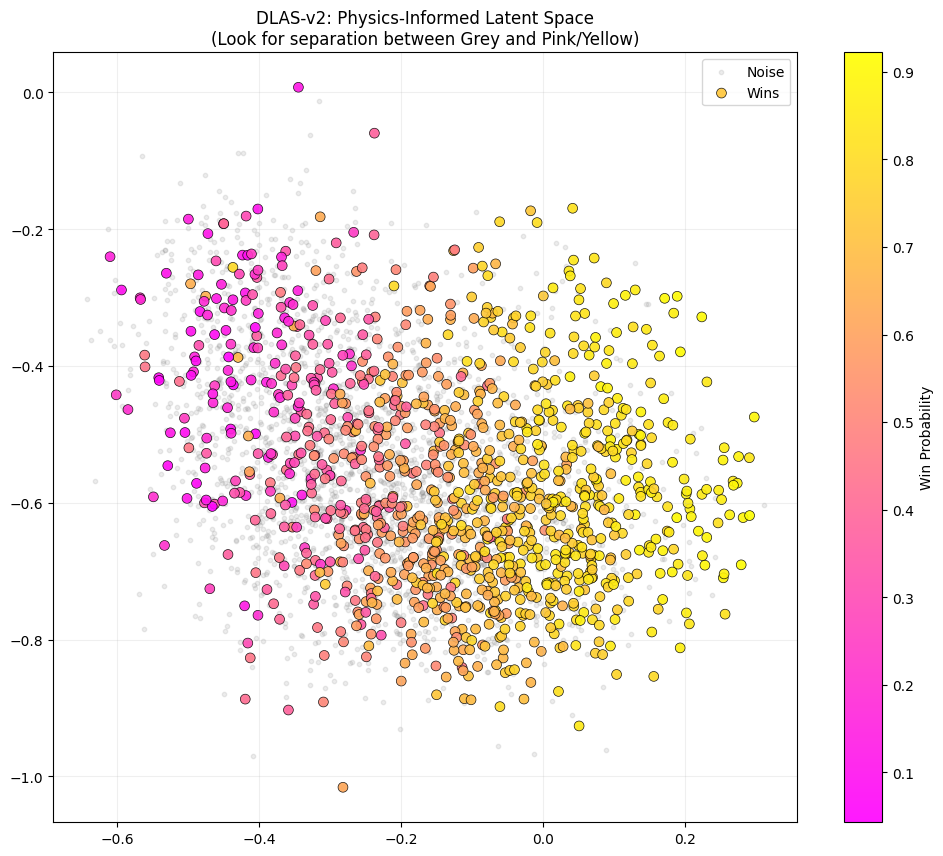

In [ ]:
# --- CELL 7: Visualization V2 ---

def visualize_physics_space(model, loader):
    model.eval()
    xy_points = []
    probs = []
    targets = []

    with torch.no_grad():
        for x, y, w in loader:
            x = x.to(device)
            _, logits, xy = model(x)

            p = torch.sigmoid(logits)

            xy_points.append(xy.cpu().numpy())
            probs.append(p.cpu().numpy())
            targets.append(y.numpy())

    xy_points = np.concatenate(xy_points, axis=0)
    probs = np.concatenate(probs, axis=0).flatten()
    targets = np.concatenate(targets, axis=0).flatten()

    plt.figure(figsize=(12, 10))

    # Noise
    plt.scatter(xy_points[:, 0], xy_points[:, 1], c='gray', alpha=0.15, s=10, label='Noise')

    # Wins
    mask = targets == 1
    if mask.sum() > 0:
        sc = plt.scatter(xy_points[mask, 0], xy_points[mask, 1],
                         c=probs[mask], cmap='spring',
                         s=50, edgecolors='black', linewidth=0.5, alpha=0.9, label='Wins')
        plt.colorbar(sc, label='Win Probability')

    plt.title('DLAS-v2: Physics-Informed Latent Space\n(Look for separation between Grey and Pink/Yellow)')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

visualize_physics_space(model, test_loader)

Running Smart Backtest (Trend Filtered)...

--- SMART FILTERED RESULTS ---
Trades: 49
Win Rate: 30.61%
Profit Factor: 0.36
Total Return: -5.62%


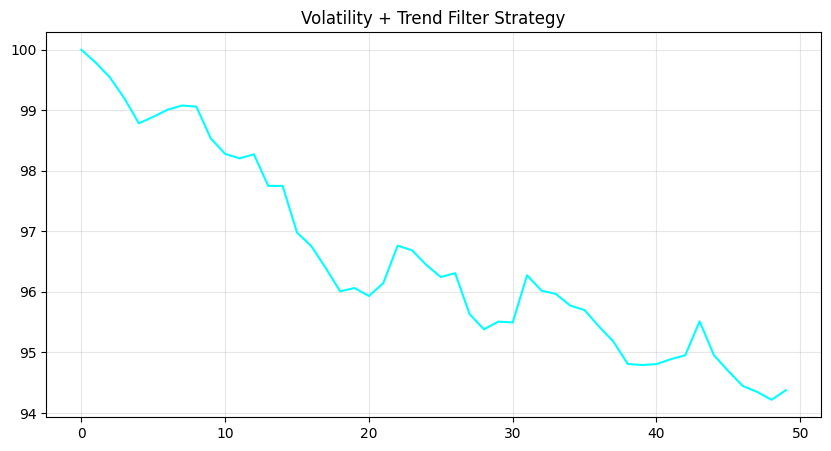

In [ ]:
# --- CELL 9: Smart Trend-Filtered Backtest ---

class SmartBacktester:
    def __init__(self, model, features, raw_df, split_idx, seq_len=128):
        self.model = model
        self.features = torch.FloatTensor(features).permute(1, 0).to(device)
        self.raw_df = raw_df.copy()
        self.split_idx = split_idx
        self.seq_len = seq_len

        # Pre-calculate Trend Indicator (EMA 50)
        self.raw_df['EMA_50'] = self.raw_df['Close'].ewm(span=50, adjust=False).mean()
        # Calculate ATR for dynamic TP/SL
        self.raw_df['TR'] = np.maximum(
            self.raw_df['High'] - self.raw_df['Low'],
            np.abs(self.raw_df['High'] - self.raw_df['Close'].shift(1))
        )
        self.raw_df['ATR'] = self.raw_df['TR'].rolling(24).mean()

    def run(self, threshold=0.85, tp_mult=1.5, sl_mult=1.0, cost_pct=0.001):
        print(f"Running Smart Backtest (Trend Filtered)...")

        self.model.eval()
        predictions = []

        # Inference Loop
        test_feats = self.features[:, self.split_idx:]
        N_test = test_feats.shape[1]

        with torch.no_grad():
            for t in range(N_test - self.seq_len):
                x_window = test_feats[:, t : t+self.seq_len].unsqueeze(0)
                _, logits, _ = self.model(x_window)
                prob = torch.sigmoid(logits).item()
                predictions.append(prob)

        equity = [100.0]
        trades = []
        start_candle_idx = self.split_idx + self.seq_len - 1

        for i, prob in enumerate(predictions):
            curr_idx = start_candle_idx + i
            if curr_idx + 1 >= len(self.raw_df): break

            curr_row = self.raw_df.iloc[curr_idx]
            next_row = self.raw_df.iloc[curr_idx + 1]

            # --- FILTER LOGIC ---
            trend_up = curr_row['Close'] > curr_row['EMA_50']
            trend_down = curr_row['Close'] < curr_row['EMA_50']

            if prob > threshold:
                atr = curr_row['ATR']
                if np.isnan(atr): continue

                trade_res = 0.0
                executed = False
                type_t = ''

                # LONG SETUP (Only if Trend UP)
                if trend_up:
                    trigger = curr_row['High']
                    # Check execution on Next Candle
                    if next_row['High'] > trigger:
                        entry = trigger
                        tp = entry + (atr * tp_mult)
                        sl = entry - (atr * sl_mult)

                        # Simulation: Did we hit TP or SL first?
                        # On 1H OHLC we can't know for sure, so we assume Worst Case (SL)
                        # if Low hit SL, unless Low didn't hit SL and High hit TP.

                        # Conservative Logic:
                        if next_row['Low'] <= sl:
                            exit_p = sl
                        elif next_row['High'] >= tp:
                            exit_p = tp
                        else:
                            exit_p = next_row['Close'] # Time exit

                        gross_pnl = (exit_p - entry) / entry
                        trade_res = gross_pnl - cost_pct
                        executed = True
                        type_t = 'Long'

                # SHORT SETUP (Only if Trend DOWN)
                elif trend_down:
                    trigger = curr_row['Low']
                    if next_row['Low'] < trigger:
                        entry = trigger
                        tp = entry - (atr * tp_mult)
                        sl = entry + (atr * sl_mult)

                        if next_row['High'] >= sl:
                            exit_p = sl
                        elif next_row['Low'] <= tp:
                            exit_p = tp
                        else:
                            exit_p = next_row['Close']

                        gross_pnl = (entry - exit_p) / entry
                        trade_res = gross_pnl - cost_pct
                        executed = True
                        type_t = 'Short'

                if executed:
                    equity.append(equity[-1] * (1 + trade_res))
                    trades.append({'PnL': trade_res, 'Type': type_t})

        return pd.DataFrame(trades), pd.Series(equity)

# --- RUN ---
# Используем ту же модель и данные
smart_bt = SmartBacktester(model, features, df_raw, split)

# Параметры: TP = 1.5 ATR, SL = 1.0 ATR (Risk Ratio 1.5)
res_df, smart_eq = smart_bt.run(threshold=0.85, tp_mult=1.5, sl_mult=1.0)

if len(res_df) > 0:
    win_rate = (res_df['PnL'] > 0).mean()
    profit_factor = abs(res_df[res_df['PnL'] > 0]['PnL'].sum() / res_df[res_df['PnL'] <= 0]['PnL'].sum())

    print(f"\n--- SMART FILTERED RESULTS ---")
    print(f"Trades: {len(res_df)}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Total Return: {smart_eq.iloc[-1] - 100:.2f}%")

    plt.figure(figsize=(10, 5))
    plt.plot(smart_eq, label='Trend Filtered Equity', color='cyan')
    plt.title('Volatility + Trend Filter Strategy')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No trades found.")